# <center> **Motorica SkillFactory internship test task 2023-12**

## Импорт библиотек и чтение данных

In [1]:
# работа с массивами/таблицами
import numpy as np
import pandas as pd

# визуализация
import seaborn as sns
from matplotlib import pyplot as plt

# преобразование и моделирование
import sklearn.linear_model as lm
import sklearn.metrics as m 
import sklearn.model_selection as ms
import sklearn.tree as t 
import sklearn.ensemble as ens 
import sklearn.preprocessing as pp
import sklearn.svm as svm 
import sklearn.pipeline as pl
import sklearn.base as b

# чтобы предупреждения не мешали
import warnings
warnings.filterwarnings('ignore')

import pickle
import dill 

plt.style.use('bmh')

# для random_state
SEED = 3

In [2]:
# факторы
X_train = np.load('data/X_train.npy')
X_test = np.load('data/X_test.npy')

# целевые переменные
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/sample_submission.csv')

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(323, 40, 100) (32300, 2)
(54, 40, 100) (5400, 2)


## Объяснение данных

Данные с факторами представляют из себя трехмерные массивы. Чтобы выполнить задачу классификации, их нужно перевести в двумерный формат. 

Можно заметить, что число наблюдений в `X_train` - это просто число наблюдений из `y_ytain` поделенное на количество временных отметок в `X_train`. 

In [3]:
X_train.shape[0] == y_train.shape[0] / X_train.shape[2]

True

А это значит, что мы сможем **вертикально соединить** каждый двумерный массив из `X_train`, находящийся на оси времени. Таким образом мы получим таблицу, у которой размерность по оси наблюдений совпадает с целевой переменной. 

С `X_test` поступим также, так как там работает тот же принцип. 

## Преобразование данных

In [4]:
class TensorToMatrix(b.TransformerMixin):
    
    def __init__(self) -> None:
        """Класс-трансформер, который преобразовывает данные в удобный для обучения вид."""
        pass 
    
    def fit(self, tensor, y=None):
        """Обучение трансформера.
        
        Args:
        ---
            tensor (`ArrayLike`): массив 
            
        Returns:
        ---
            `TensorToMatrix`: обученный трансформер
        """
        return self
    
    def transform(self, tensor, y=None):
        """Трансформация трехмерного массива в двумерный. 

        Args:
        ---
            tensor (`ArrayLike`): трехмерный массив

        Returns:
        ---
            `NDArray`: двумерный массив 
        """
        # перебираем двумерные массивы и заносим их в список
        samples = []
        
        for X in tensor:
            # добавляем в данные также временные отметки
            timesteps = np.arange(X.shape[1])
            
            # не забываем транспонировать массивы, чтобы строки и столбцы были на своих местах
            X_transformed = np.column_stack((X.T, timesteps))
            samples.append(X_transformed)
            
        # результат - вертикально соединенный массив
        return np.row_stack(samples)
    
    def fit_transform(self, tensor, y=None):
        return self.fit(tensor).transform(tensor)


X_train_2d = TensorToMatrix().fit_transform(X_train)
X_test_2d = TensorToMatrix().fit_transform(X_test)

Теперь посмотрим, как выглядят получившиеся таблицы. Для проверки корректности работы функции, попробую установить на них столбцы с отметками из `y_train` и `y_test` в качестве индексов.

In [5]:
pd.DataFrame(X_train_2d, index=y_train['sample-timestep']) 

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
sample-timestep,,,,,,,,,,,,,,,,,,,,,
0-0,1123.0,10.0,1450.0,64.0,34.0,1743.0,145.0,12.0,1068.0,14.0,...,73.0,13.0,1169.0,129.0,29.0,1677.0,36.0,718.0,26.0,0.0
0-1,1125.0,7.0,1441.0,66.0,33.0,1738.0,143.0,17.0,1064.0,0.0,...,70.0,20.0,1170.0,132.0,28.0,1673.0,28.0,730.0,25.0,1.0
0-2,1121.0,17.0,1444.0,60.0,32.0,1732.0,141.0,10.0,1065.0,14.0,...,77.0,14.0,1169.0,130.0,30.0,1670.0,29.0,727.0,27.0,2.0
0-3,1120.0,10.0,1440.0,59.0,32.0,1730.0,143.0,6.0,1066.0,13.0,...,68.0,13.0,1165.0,131.0,29.0,1667.0,24.0,726.0,34.0,3.0
0-4,1115.0,16.0,1437.0,51.0,30.0,1724.0,138.0,4.0,1062.0,12.0,...,73.0,9.0,1165.0,133.0,29.0,1667.0,32.0,724.0,24.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322-95,1679.0,17.0,1826.0,36.0,26.0,2250.0,43.0,5.0,1369.0,28.0,...,71.0,19.0,1186.0,108.0,26.0,1689.0,25.0,388.0,27.0,95.0
322-96,1673.0,4.0,1827.0,35.0,25.0,2251.0,42.0,10.0,1371.0,19.0,...,72.0,15.0,1204.0,106.0,25.0,1690.0,32.0,388.0,27.0,96.0
322-97,1669.0,10.0,1832.0,33.0,30.0,2251.0,38.0,1.0,1369.0,18.0,...,66.0,14.0,1203.0,107.0,27.0,1690.0,16.0,390.0,27.0,97.0


In [6]:
pd.DataFrame(X_test_2d, index=y_test['sample-timestep']) 

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
sample-timestep,,,,,,,,,,,,,,,,,,,,,
323-0,1681.0,4.0,1834.0,33.0,26.0,2254.0,43.0,0.0,1376.0,27.0,...,82.0,16.0,1204.0,108.0,25.0,1685.0,27.0,386.0,25.0,0.0
323-1,1679.0,17.0,1826.0,36.0,26.0,2250.0,43.0,5.0,1369.0,28.0,...,71.0,19.0,1186.0,108.0,26.0,1689.0,25.0,388.0,27.0,1.0
323-2,1673.0,4.0,1827.0,35.0,25.0,2251.0,42.0,10.0,1371.0,19.0,...,72.0,15.0,1204.0,106.0,25.0,1690.0,32.0,388.0,27.0,2.0
323-3,1669.0,10.0,1832.0,33.0,30.0,2251.0,38.0,1.0,1369.0,18.0,...,66.0,14.0,1203.0,107.0,27.0,1690.0,16.0,390.0,27.0,3.0
323-4,1670.0,3.0,1831.0,36.0,28.0,2249.0,40.0,8.0,1368.0,18.0,...,76.0,30.0,1207.0,107.0,26.0,1691.0,29.0,391.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376-95,1887.0,16.0,1856.0,43.0,53.0,2308.0,61.0,16.0,1444.0,24.0,...,60.0,11.0,1166.0,120.0,28.0,1675.0,36.0,316.0,29.0,95.0
376-96,1884.0,17.0,1850.0,27.0,45.0,2304.0,61.0,7.0,1441.0,25.0,...,69.0,3.0,1166.0,122.0,28.0,1668.0,29.0,315.0,29.0,96.0
376-97,1882.0,13.0,1843.0,37.0,51.0,2299.0,60.0,1.0,1437.0,25.0,...,75.0,18.0,1167.0,119.0,28.0,1676.0,26.0,313.0,30.0,97.0


Функция работает корректно.

Замечу, что `y_test` мы не будем использовать для валидации модели, так как задача этого не предполагает. Нам нужно эту переменную заново создать самим и отправить на Kaggle в качестве сабмишшна. 

Поэтому для обучения воспользуемся только `y_train`, нам из него нужен только столбец с классом.

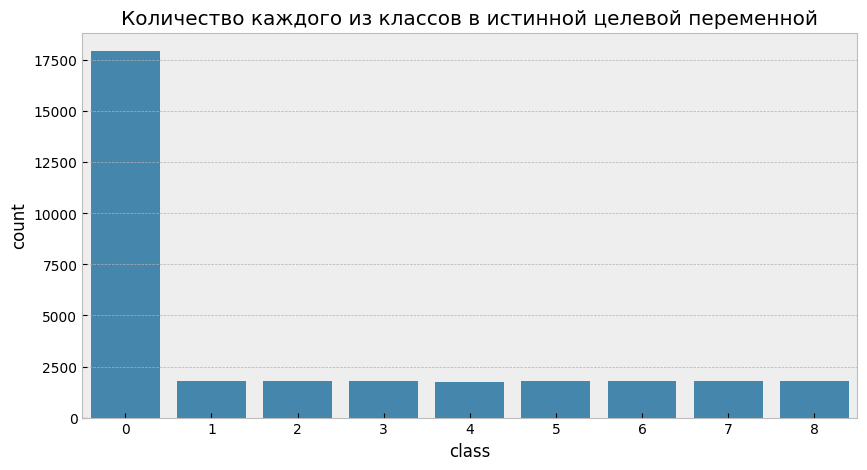

In [7]:
y_train_2d = y_train['class']

plt.figure(figsize=(10, 5))
sns.barplot(y_train_2d.value_counts())

plt.title('Количество каждого из классов в истинной целевой переменной')
plt.show()

Считаю необходимым также стандартизировать данные, поскольку так модели будет проще обучаться. 

In [8]:
scaler = pp.StandardScaler()

# обучим скейлер на всех данных, для лучшей точности
X_full = np.row_stack((X_train_2d, X_test_2d))
scaler.fit(X_full)

X_train_scaled = scaler.transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

Посмотрим, как они выглядят теперь.

In [9]:
X_train_scaled

array([[ 0.15634284, -0.06950633,  0.40318652, ...,  1.17222523,
         0.51985332, -1.71481604],
       [ 0.1629748 , -0.5294926 ,  0.3829491 , ...,  1.24334451,
         0.27257897, -1.68017329],
       [ 0.14971088,  1.00379499,  0.38969491, ...,  1.22556469,
         0.76712766, -1.64553055],
       ...,
       [ 1.96686808, -0.06950633,  1.26215239, ..., -0.7717017 ,
         0.76712766,  1.64553055],
       [ 1.97018407, -1.14280764,  1.25990379, ..., -0.7657751 ,
        -4.92018227,  1.68017329],
       [ 1.95692014, -0.37616384,  1.25540658, ..., -0.72428885,
         0.51985332,  1.71481604]])

In [10]:
X_test_scaled

array([[ 2.00665985, -0.98947888,  1.26664959, ..., -0.79540813,
         0.27257897, -1.71481604],
       [ 2.00002789,  1.00379499,  1.24866078, ..., -0.78355492,
         0.76712766, -1.68017329],
       [ 1.98013201, -0.98947888,  1.25090938, ..., -0.78355492,
         0.76712766, -1.64553055],
       ...,
       [ 2.67317189,  0.39047995,  1.28688701, ..., -1.22805041,
         1.50895069,  1.64553055],
       [ 2.68643581,  0.54380871,  1.26889819, ..., -1.19841737,
         2.00349938,  1.68017329],
       [ 2.63006414,  0.23715119,  1.23516917, ..., -1.21027059,
         1.01440201,  1.71481604]])

## Разработка модели

Сначала рассмотрим самые простые модели, а затем постепенно будем переходить к более сложным. Для успешного обучения и оптимизации модели я создам функцию, которая делает данный процесс автоматическим.

Алгоритм будет состоять из 3 шагов:
1. Обучить модель с параметрами по умолчанию и вычислить метрики модели на тренировочной и валидационной выборках.
2. Подобрать гиперпараметры по сетке и выделить модель с наилучшими параметрами.
3. Обучить оптимизованную модель и сравнить ее метрики с метриками первичной модели.

> Так как оценивание на Kaggle происходит по метрике F1, то будем использовать ее. Так как перед нами стоит задача мультиклассовой классификации, в самой метрике нужно задать параметр `average`, а поскольку классы несбалансированы, то зададим мы его как `'weighted'`. Итого конечная метрика будет задана как `'f1_weighted'`.

In [11]:
def make_crossval(model, X, y, message=''):
    """Функция для кросс-валидации.

    Args:
    ---
        model (`BaseEstimator`): модель 
        X (`ArrayLike`): матрица факторов 
        y (`ArrayLike`): вектор целевой переменной
        message (`str`, optional): дополнительное сообщение выводимое на экран, по умолчанию не выводится

    Выводит на экран сообщения со средними значениями метрик на тренировочной и валидационной выборках."""
    
    cv_result = ms.cross_validate(model, X, y, 
                                  scoring='f1_weighted', 
                                  n_jobs=-1, 
                                  return_train_score=True)
    
    train_test_scores = (cv_result['train_score'].mean().round(2), 
                         cv_result['test_score'].mean().round(2))
    
    print(f'Train    F1 score{message}: {train_test_scores[0]}')
    print(f'CrossVal F1 score{message}: {train_test_scores[1]}')


def optimise_model_cv(model, 
                      params,
                      X_train=X_train_scaled, 
                      y_train=y_train_2d):
    """Функция автоматизирует процесс обучения модели и оптимизации ее гиперпараметров с кросс-валидацией.\n
    На каждой стадии процесса на экран выводятся значения метрик и словарь подобранных гиперпараметров.
    
    Args:
    ---
        model (`BaseEstimator`): модель с параметрами по умолчанию
        params (`dict`): словарь-сетка гиперпараметров для оптимизации
        X_train (`ArrayLike`, optional): матрица факторов 
        y_train (`ArrayLike`, optional): вектор целевой переменной
        
    Returns:
    ---
        `BaseEstimator`: оптимизированная модель"""
    
    # 1. Обучение модели с параметрами по умолчанию
    make_crossval(model, 
                  X_train, 
                  y_train, 
                  message=' (default)')
    
    # 2. Подбор гиперпараметров модели
    optimiser = ms.GridSearchCV(estimator=model, 
                                param_grid=params, 
                                scoring='f1_weighted', 
                                n_jobs=-1)
    optimiser.fit(X_train, y_train)

    print(f'\nBest model has such params: {optimiser.best_params_}\n')
    
    # 3. Сравнение метрик оптимизованной модели с метриками первичной модели 
    make_crossval(optimiser.best_estimator_, 
                  X_train, 
                  y_train, 
                  message=' (optimised)')
    
    return optimiser.best_estimator_

### *Logistic Regression*

In [12]:
lr_model = lm.LogisticRegression(random_state=SEED, n_jobs=-1)

lr_params = {'multi_class': ['ovr', 'multinomial'], 
             'solver': ['lbfgs', 'newton-cg', 'sag', 'saga']}

lr_opt_model = optimise_model_cv(lr_model, lr_params)

Train    F1 score (default): 0.82
CrossVal F1 score (default): 0.77

Best model has such params: {'multi_class': 'ovr', 'solver': 'saga'}

Train    F1 score (optimised): 0.82
CrossVal F1 score (optimised): 0.79


### *Stochastic Gradient Descend*

In [13]:
sgd_model = lm.SGDClassifier(random_state=SEED, n_jobs=-1)

sgd_params = {'alpha': [0.001, 0.01, 0.1], 
              'learning_rate': ['constant', 'optimal', 'adaptive'], 
              'eta0': [1, 10, 100]}

sgd_opt_model = optimise_model_cv(sgd_model, sgd_params) 

Train    F1 score (default): 0.82
CrossVal F1 score (default): 0.8

Best model has such params: {'alpha': 0.01, 'eta0': 10, 'learning_rate': 'adaptive'}

Train    F1 score (optimised): 0.82
CrossVal F1 score (optimised): 0.81


### *Decision Tree*

In [14]:
dt_model = t.DecisionTreeClassifier(random_state=SEED)

dt_params = {'max_depth': [2, 4, 6], 
             'min_samples_leaf': [1, 2, 3], 
             'criterion': ['gini', 'entropy']}

dt_opt_model = optimise_model_cv(dt_model, dt_params)

Train    F1 score (default): 1.0
CrossVal F1 score (default): 0.78

Best model has such params: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 2}

Train    F1 score (optimised): 0.83
CrossVal F1 score (optimised): 0.77


### *Random Forest*

In [15]:
rf_model = ens.RandomForestClassifier(random_state=SEED, n_jobs=-1)

rf_params = {'n_estimators': [100, 300], 
             'max_depth': [2, 4, 6], 
             'criterion': ['gini', 'entropy']}

rf_opt_model = optimise_model_cv(rf_model, rf_params)

Train    F1 score (default): 1.0
CrossVal F1 score (default): 0.85

Best model has such params: {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 300}

Train    F1 score (optimised): 0.81
CrossVal F1 score (optimised): 0.77


### *Support Vector Machine*

In [16]:
svm_model = svm.SVC(kernel='linear', random_state=SEED)

svm_params = {'kernel': ['poly', 'rbf', 'sigmoid']}

svm_opt_model = optimise_model_cv(svm_model, svm_params)

Train    F1 score (default): 0.83
CrossVal F1 score (default): 0.79

Best model has such params: {'kernel': 'rbf'}

Train    F1 score (optimised): 0.85
CrossVal F1 score (optimised): 0.82


Согласно метрикам лучше всего справились с заданием 2 модели - `SVC` и `SGDClassifier`, их валидационные показатели - **0.82** и **0.81** соответственно. Но разница в том, что первая имеет расхождение между тренировочным и валидационным показателями в **3%**, тогда как последняя - всего в **1%**. 

Поэтому окончательный выбор - **`SGDClassifier`**.

## Пайплайн

Попробуем создать пайплайн и проверим, работает ли он.

In [17]:
pipeline = pl.Pipeline([('reshaper', TensorToMatrix()), 
                        ('scaler', scaler), 
                        ('model', sgd_opt_model)])

%time pipeline.predict(X_train)

CPU times: total: 0 ns
Wall time: 25.7 ms


array([0, 0, 0, ..., 4, 4, 4], dtype=int64)

In [18]:
make_crossval(pipeline.named_steps['model'], 
              pipeline.decision_function(X_train), 
              y_train_2d) 

Train    F1 score: 0.82
CrossVal F1 score: 0.82


Отлично! Все прекрасно работает. Мало того, что в модель теперь можно спокойно передавать данные требуемой размерности, так еще и эффективность ее повысилась до уровня `SVC` и разница между тренировочным и валидационным показателями устранена. 

Однако еще рано радоваться, поскольку целевые переменные представлены здесь не в оригинальном виде, а в удобном для Kaggle. 
Согласно техническим требованиям (из `README`) они должны выглядеть вот так (на примере `y_train`):

In [19]:
y_train_3d = y_train.copy()

y_train_3d[['sample_id', 'timestep']] = (y_train_3d['sample-timestep']
                                         .str.split(pat='-', n=1, expand=True)
                                         .astype(int))

y_train_3d = y_train_3d.pivot(index='sample_id', 
                              columns='timestep', 
                              values='class')

y_train_3d 

timestep,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
sample_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6
3,6,6,6,6,6,6,6,6,6,6,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,0,0,0,0,0,0,0,0,0,0,...,8,8,8,8,8,8,8,8,8,8
319,8,8,8,8,8,8,8,8,8,8,...,0,0,0,0,0,0,0,0,0,0
320,0,0,0,0,0,0,0,0,0,0,...,7,7,7,7,7,7,7,7,7,7


Значит и получившиеся предсказания нужно также перевести в данный формат. К ожалению, я не смогу настроить пайплайн так, чтобы он возвращал подобную матрицу, поэтому я создам собственный класс, который будет работать так, как нам нужно. 

Для этого мой пайплайн нужно сохранить.

In [20]:
class MotoricaPipeline(b.BaseEstimator):
    def __init__(self) -> None:
        """_summary_
        """
        pass
    
    def fit(self, X):
        with open('./motorica_pl.pkl', 'rb') as pl_file:
            self.pipeline = pickle.load(pl_file)
            
        return self 
    
    def predict(self, X, as_df=False):
        y = np.split(self.pipeline.predict(X), X.shape[0])
    
        if as_df:
            y_inxcol = pd.Series(range(len(y)), name='sample_id')
            y_header = pd.Series(range(len(y[0])), name='timestep')

            y = pd.DataFrame(y)
            
            return y.set_index(y_inxcol).T.set_index(y_header).T
        
        return np.array(y) 
    
    def fit_predict(self, X, as_df=False):
        return self.fit(X).predict(X, as_df=as_df)
    
    
MotoricaPipeline().fit_predict(X_train)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 6, 6],
       ...,
       [0, 0, 0, ..., 7, 7, 7],
       [7, 7, 7, ..., 0, 0, 0],
       [0, 0, 0, ..., 4, 4, 4]], dtype=int64)

In [21]:
jvjgvh

NameError: name 'jvjgvh' is not defined

In [ ]:
def pipeline_predict(X, pl=pipeline, as_df=False):    
    y = np.split(pl.predict(X), X.shape[0])
    
    if as_df:
        y_inxcol = pd.Series(range(len(y)), name='sample_id')
        y_header = pd.Series(range(len(y[0])), name='timestep')

        y = pd.DataFrame(y)
        
        return y.set_index(y_inxcol).T.set_index(y_header).T
    
    return np.array(y)


# попробуем предсказать значения для 10 случайных человек
rand_i = np.random.randint(0, X_train.shape[0], size=10)
X_rand = X_train[rand_i]

%time pipeline_predict(X_rand, as_df=True)

Способ работает. Теперь я могу сохранить мой пайплайн

---

# <center> **SUBMISSION**

In [ ]:
y_test['class'] = pipeline.predict(X_test)
y_test.to_csv('data/y_test_predicted.csv', index=False)

plt.figure(figsize=(10, 5))
sns.barplot(y_test['class'].value_counts())

plt.title('Количество каждого из классов в предсказанной целевой переменной')
plt.show() 